# <center> Training a LeNet-5 CKN on MNIST with XSDC </center>
The XSDC algorithm provides an approach to end-to-end learning that allows one to jointly learn a feature
representation from unlabeled data (with or without labeled data) and predict labels for unlabeled
data. It is domain-agnostic and can be used with any amount of labeled and unlabeled data, gracefully
adjusting to the amount of supervision.

In this notebook we'll set up and train a LeNet-5 convolutional kernel network (see [Jones et al., 2019](https://arxiv.org/pdf/1903.08131.pdf) for how LeNet-5 was translated to a convolutional kernel network) on the dataset MNIST using XSDC. 

## 1 Setting up the data
There are five main items we need to set up: the data, model, training parameters, and results and optimizer objects. First we'll set up the data. For this we need to first load the default parameters and the MNIST data loader code:

In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')

from src import default_params as defaults
import src.data_loaders.mnist as mnist

There are several parameters we need to set:
- num_labeled: The number of labeled observations in the training set.
- batch_size: The batch size to use for both the labeled data and the unlabeled data.
- data_path: The directory where the data resides or will reside. For MNIST and CIFAR-10 if the data doesn't already exist there it will be automatically downloaded and saved there.

The additional parameters stratified_unlabeling specifies whether, when removing labels to create the unlabeled training set, this should be done in a stratified manner or uniformly at random.

In [2]:
num_labeled = 50  
batch_size = 1024
data_path = '../data/mnist'
seed = 1

In [3]:
import numpy as np
import random
import torch
torch.set_default_tensor_type(torch.FloatTensor)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [4]:
# Create the data loaders
train_loader, _, train_labeled_loader, train_unlabeled_loader, valid_loader, train_valid_loader, test_loader = \
    mnist.get_dataloaders(batch_size=batch_size, batch_size_labeled=batch_size,
                          batch_size_unlabeled=batch_size, num_labeled=num_labeled,
                          stratified_unlabeling=True, data_path=data_path, num_workers=0, seed=seed)

Number of labeled data points being used: 50


We have six different data loaders: 
- train_loader: Data loader that contains both the labeled and unlabeled observations in the training set
- train_labeled_loader: Data loader that contains the labeled observations in the training set
- train_unlabeled_loader: Data loader that contains the unlabeled observations in the training set
- valid_loader: Data loader that contains the observations in the validation set
- train_valid_loader: Data loader that contains the observations in both the training and validation sets
- test_loader: Data loader that contains the observations in the test set

Now we will create a Data object that contains the relevant data loaders and which will be used by XSDC:

In [5]:
from src.opt import opt_structures
data = opt_structures.Data(train_labeled_loader, train_unlabeled_loader, valid_loader, train_valid_loader, 
                           test_loader)

## 2 Setting up the model
Next we'll set up the model. The model is specified in a config file. This file is loaded and parsed, and then the model is initialized.

In [6]:
from src.model.ckn import parse_config, net

Loading faiss with AVX2 support.


There are two parameters we will change from the version of the network specified in the config file:
1. The number of filters at each layer
2. The bandwidths of the kernels

We'll use a small model, so we'll set the number of filters per layer to 32. The bandwidth of 0.6 was found by Jones et al. (2019) using cross-validation.

In [7]:
num_filters = 32
bandwidth = 0.6

In [8]:
# Load the parameters of the network
params = parse_config.load_config('../cfg/lenet-5_ckn.cfg')

# Change the number of filters per layer and the bandwidths of the kernels
nlayers = len(params['num_filters'])
params['num_filters'] = [num_filters] * nlayers
params['patch_sigma'] = [bandwidth] * nlayers

# Create the network
layers = parse_config.create_layers(params)
model = net.CKN(layers).to(defaults.device)

# # Initialize the network
model.init(train_loader)
print('Done with initialization')

Initializing layer 0
Initializing layer 1
Initializing layer 2
Initializing layer 3
Initializing layer 4
Initializing layer 5
Done with initialization


The network has now been initialized. We just need to create an object of the `Model` class for XSDC. We'll save the model after training to the file `../output/temp_model.pickle`.

In [9]:
import os

save_file = os.path.join('..', 'output', 'temp')
model = opt_structures.Model(model, save_path=save_file + '_model.pickle')

## 3 Setting up the parameters
Finally, we'll set up the parameters. There are a large number of parameters that we can specifiy for XSDC. These include the following:

In [10]:
nclasses = 10                # Number of classes in the dataset
min_frac_points_class = 0.1  # Minimum fraction of points per class in the dataset
max_frac_points_class = 0.1  # Maximum fraction of points per class in the dataset
project = True               # Whether to project the patches onto the unit sphere at each layer
normalize = True             # Whether to normalize the features after they are output by the network
labeling_burnin = 100        # Number of iterations for which it will train on only the labeled data to start
lr_sup_init = 2**-7          # Learning rate when training on only the labeled data
lr_semisup = 2**-6           # Learning rate when training on the labeled + unlabeled data
num_iters = 300              # Number of iterations for which it will run
save_path = save_file + '_params.pickle' # File where the parameters will be saved
save_every = 50              # How often to save the model, parameters, and results (after how many iterations)
train_w_layers = [0, 2, 4, 5]  # Layers of the network whose parameters should be trained

We'll run XSDC for 300 iterations.

In [11]:
params = opt_structures.Params(nclasses=nclasses, min_frac_points_class=min_frac_points_class,
                               max_frac_points_class=max_frac_points_class, project=project,
                               train_w_layers=train_w_layers, normalize=normalize, 
                               labeling_burnin=labeling_burnin, step_size_init_sup=lr_sup_init,
                               step_size_init_semisup=lr_semisup, maxiter=num_iters, save_every=save_every,
                               save_path=save_file + '_params.pickle',
                               )

## 4 Setting up the results and training objects
The last things we need to set up are the object that will store the results and the optimizer object.

In [12]:
from src.opt import train_xsdc

save_path = save_file + '_results.pickle'
results = opt_structures.Results(save_path=save_path)

optimizer = train_xsdc.TrainSupervised(data, model, params, results)

## 5 Training with XSDC
Now we're ready to train with XSDC! 

In [13]:
optimizer.train()

Iteration 	 Test accuracy 	 Test loss
0 		 0.7228 	 0.4627
10 		 0.7291 	 0.4508
20 		 0.7354 	 0.4439
30 		 0.7384 	 0.4393
40 		 0.7418 	 0.4357
50 		 0.7433 	 0.4338
60 		 0.7456 	 0.4330
70 		 0.7449 	 0.4330
80 		 0.7460 	 0.4323
90 		 0.7454 	 0.4323
100 		 0.7439 	 0.4332
110 		 0.7778 	 0.3928
120 		 0.7763 	 0.3879
130 		 0.7704 	 0.3905
140 		 0.7773 	 0.3822
150 		 0.7859 	 0.3741
160 		 0.7936 	 0.3639
170 		 0.7963 	 0.3560
180 		 0.7951 	 0.3561
190 		 0.8047 	 0.3425
200 		 0.8212 	 0.3257
210 		 0.8122 	 0.3448
220 		 0.8053 	 0.3428
230 		 0.7961 	 0.3441
240 		 0.7983 	 0.3360
250 		 0.7972 	 0.3416
260 		 0.7970 	 0.3493
270 		 0.7987 	 0.3539
280 		 0.7931 	 0.3631
290 		 0.7876 	 0.3699
300 		 0.7956 	 0.3793
Done training. Saving final results.
300 		 0.7956 	 0.3792


## 6 Examining the results
Now we can load and plot the results. First, we can look at the accuracy across iterations. The particular seed we used happens to yield a lower accuracy after 100 iterations (the end of the supervised initialization) and a lower overall accuracy than many other seeds.

In /home/cjones6/anaconda2/envs/python37pytorch1/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/cjones6/anaconda2/envs/python37pytorch1/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/cjones6/anaconda2/envs/python37pytorch1/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


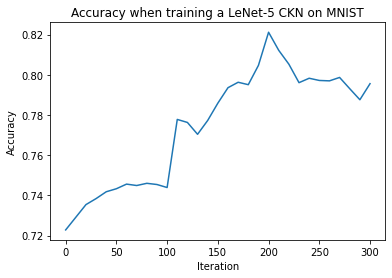

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

results = pickle.load(open(save_file + '_results.pickle', 'rb'))

plt.plot(list(results['test_accuracy'].keys()), list(results['test_accuracy'].values()))
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy when training a LeNet-5 CKN on MNIST')
plt.show()

We can also visualize the resultant features projected to 2D using t-SNE. Here we first create a grid. For each square in the grid, the code checks whether any image’s t-SNE representation lies in that square. If any such images exist, it chooses one at random and displays the original image in that square. The images are color-coded according to the ground-truth labels.

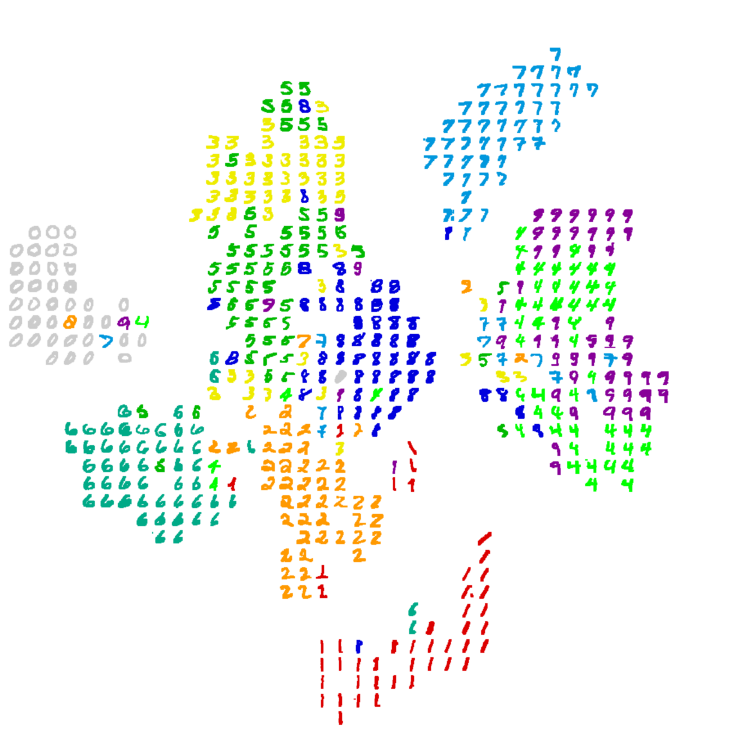

In [16]:
import matplotlib
import numpy as np
import torch

sys.path.append('../src/opt')

import opt_utils
import tsne_visualization

matplotlib.rcParams['figure.figsize'] = (10, 10)

# Load the trained model
model = opt_structures.Model()
model.load(save_file + '_model_300.pickle')

# Compute the features and labels for 4096 observations
torch.cuda.empty_cache()
x_unlab_all = []
features_all = []
y_unlab_all = []
for i in range(4):
    x_unlab, y_unlab, y_unlab_truth = next(iter(train_unlabeled_loader))
    x_unlab_all.append(x_unlab.cpu())
    features = opt_utils.compute_features(x_unlab, model, standardize=False, normalize=True).cpu().detach()
    features_all.append(features)
    y_unlab_all.append(y_unlab_truth)

x_unlab = torch.cat(x_unlab_all)
x_unlab = ((x_unlab*0.3081+0.1307))
features = torch.cat(features_all)
y_unlab_truth = torch.cat(y_unlab_all)

# Compute the embeddings
embeddings = tsne_visualization.compute_embedding(features, perplexity=35)
embeddings = (embeddings - np.min(embeddings))
embeddings /= np.max(embeddings)

# Plot the embeddings
tsne_visualization.display_color(embeddings, x_unlab, y_unlab_truth, save_file=None)